# Causal Discovery to Causal Inference
Yongwoo Jeong 

GS ITM

In [1]:
import os
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr

import graphviz
import lingam
from lingam.utils import make_dot
from graphs_analysis import make_graph, get_causal_model
from graphs_analysis import get_optimal_intervention, get_label_processing
from graphs_analysis import get_total_effect, get_intervention_effect, get_bootstrapping_prediction

import plotly
import plotly.graph_objects as go
from dowhy import CausalModel

np.set_printoptions(precision=3, suppress=True)
np.random.seed(0)

import warnings
warnings.filterwarnings('ignore')

### Dataset was collected from Yahoo Finance.

crude oil stock code: CL=F

anderson stock code : ANDE

natural gas stock code: NG=F

NVIDIA stock code: NVDA

Intel stock code: INTC

QualComm stock code: QCOM

Apple stock code: AAPL

Did they suffer or not during the Ukrainian War?

In [2]:
df = pd.read_csv("electric_goods.csv")

In [3]:
df

,Date,AAPL,NVDA,INTC,QCOM,crude_oil,natural_gas,USD
0,2021-12-30,178.199997,295.859985,51.740002,182.729996,76.989998,3.561,53.130001
1,2021-12-31,177.570007,294.109985,51.500000,182.869995,75.209999,3.730,52.820000
2,2022-01-03,182.009995,301.209991,53.209999,186.210007,76.080002,3.815,54.880001
3,2022-01-04,179.699997,292.899994,53.139999,187.229996,76.989998,3.717,53.730000
4,2022-01-05,174.919998,276.040009,53.869999,186.500000,77.849998,3.882,49.810001
...,...,...,...,...,...,...,...,...
112,2022-06-10,137.130005,169.740005,39.180000,133.199997,120.669998,8.850,23.450001
113,2022-06-13,131.880005,156.470001,37.770000,128.660004,120.930000,8.609,20.750000
114,2022-06-14,132.759995,158.360001,37.930000,130.259995,118.930000,7.189,20.959999
115,2022-06-15,135.429993,165.270004,38.650002,131.029999,115.309998,7.420,21.850000


In [5]:
X = df[['AAPL', 'NVDA', 'INTC', 'QCOM', 'crude_oil','natural_gas', 'USD']]

### causal discovery model

In [6]:
model = get_causal_model()
model.fit(X)

In [7]:
labels, df_inference = get_label_processing(X)

dag = make_graph(model.adjacency_matrix_, labels)

### This is what we found from the dataset.

The causal path is shown in the DAG

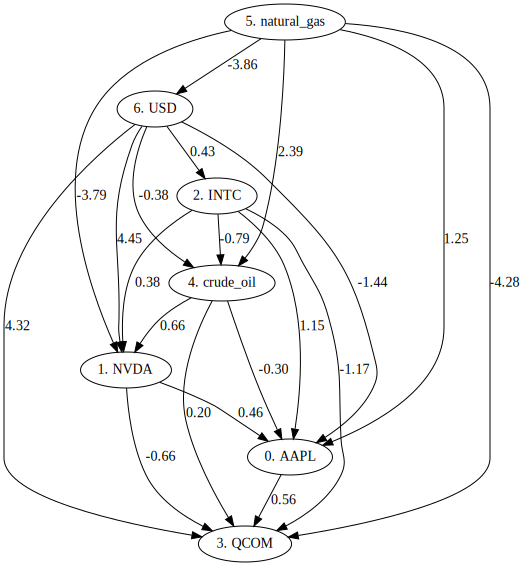

In [8]:
dag

In [9]:
labels

['0. AAPL',
 '1. NVDA',
 '2. INTC',
 '3. QCOM',
 '4. crude_oil',
 '5. natural_gas',
 '6. USD']

### crude oil price impacting on constellation
Remember this. We will use this for inference later

In [10]:
# USD -> Apple
get_total_effect(model, X, cause_index=6, result_index=0)

total effect: 1.189


In [12]:
# natural gas -> Apple
get_total_effect(model, X, cause_index=5, result_index=0)

total effect: -5.128


In [13]:
# natural gas -> NVIDIA
get_total_effect(model, X, cause_index=5, result_index=1)

total effect: -18.187


In [15]:
# Intel -> Apple
get_total_effect(model, X, cause_index=2, result_index=0)

total effect: 1.334


In [16]:
# Intel -> NVIDIA
get_total_effect(model, X, cause_index=2, result_index=1)

total effect: 0.000


In [17]:
# NVIDIA -> Intel
get_total_effect(model, X, cause_index=1, result_index=2)

total effect: 0.000


In [18]:
# Apple -> QualComm
get_total_effect(model, X, cause_index=0, result_index=3)

total effect: 0.555


In [19]:
# Intel -> QualComm
get_total_effect(model, X, cause_index=2, result_index=3)

total effect: 0.000


In [20]:
# NVIDIA -> QualComm
get_total_effect(model, X, cause_index=1, result_index=3)

total effect: -0.368


### intervention effect

What if there is no connection to the target except some intervention?

What will make more effect on the target?

In [21]:
intervention_data = get_intervention_effect(model, X, target_index=3)

### Remove all incoming arrows to the interesting interventions..

e.g. for crude_oil as intervention, we remove anderson -> crude_oil and natural_gas -> crude_oil 
<br>
but we keep natural_gas -> constellation and anderson -> constellation

In [22]:
intervention_data["intervention_effect"]

,feature,effect_plus,effect_minus
0,AAPL,4.539590,4.539590
1,NVDA,13.307152,13.307152
2,INTC,0.804842,0.804842
3,QCOM,0.000000,0.000000
4,crude_oil,3.223603,3.223603
5,natural_gas,14.807514,14.807514
6,USD,13.600588,13.600588


In [23]:
intervention_data["max_intervention_element_name"]

'natural_gas'

In [24]:
intervention_data["reg_model"]

LassoCV(cv=7, random_state=0)

In [25]:
intervention_data["causal_effect"]

In [26]:
get_optimal_intervention(X, intervention_data, intervention_index=1, target_index=3, target_value=100)

### Let's use bootstrapping to analyze this further.

In [27]:
boostrapping_result = get_bootstrapping_prediction(X, cause_index=1, target_index=3, n_sampling=100, min_causal_effect=0.01)

In [28]:
boostrapping_result["from-to-df"]

,from,to,effect,probability
0,natural_gas,USD,-3.862270,0.98
1,natural_gas,crude_oil,5.232952,0.98
2,INTC,crude_oil,-1.113554,0.85
3,natural_gas,NVDA,-18.187405,0.84
4,natural_gas,QCOM,-8.725952,0.84
5,INTC,USD,1.071557,0.76
6,AAPL,USD,0.355877,0.70
7,AAPL,crude_oil,-0.295845,0.66
8,natural_gas,AAPL,-5.127949,0.65
9,natural_gas,INTC,-1.733078,0.65


### Assume that causal effects above 70% possibility to occur are important

In [29]:
boostrapping_result["top-70%"]

,from,to,effect,probability
0,natural_gas,USD,-3.862270,0.98
1,natural_gas,crude_oil,5.232952,0.98
2,INTC,crude_oil,-1.113554,0.85
3,natural_gas,NVDA,-18.187405,0.84
4,natural_gas,QCOM,-8.725952,0.84
5,INTC,USD,1.071557,0.76


### Narrowing down to our target

It seems that crude oil has a negative causal impact on constellation about -0.93

In [30]:
boostrapping_result["effect-on-target"]

,from,to,effect,probability
4,natural_gas,QCOM,-8.725952,0.84
13,AAPL,QCOM,0.555208,0.60
14,crude_oil,QCOM,-0.291519,0.59
16,INTC,QCOM,1.958565,0.51
24,NVDA,QCOM,-0.367917,0.40
27,USD,QCOM,1.590365,0.38


In [31]:
boostrapping_result["causal-path"]

,path,effect,probability
0,"[1, 3]",-0.529464,0.40
1,"[1, 0, 3]",0.284313,0.11
2,"[1, 4, 3]",-0.067796,0.09
3,"[1, 2, 3]",0.059569,0.04
4,"[1, 2, 4, 3]",0.040754,0.04
5,"[1, 2, 5, 3]",0.012533,0.03
6,"[1, 2, 5, 4, 3]",0.009341,0.03
7,"[1, 5, 3]",0.093904,0.03
8,"[1, 5, 4, 3]",0.058817,0.03


### Causal Inference

### crude oil price impacting on constellation

And we know there are instrumental variables; anderson and natural gas

We can double-check its path again.

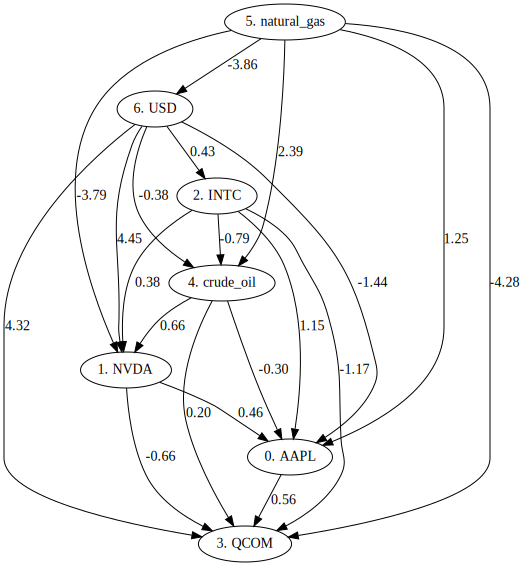

In [32]:
dag

### In dowhy, we set those instrumental variables, X and Y

In [33]:
model = CausalModel(data = df_inference,
                        treatment='1. NVDA',
                        outcome='3. QCOM',
                        common_causes=['U'],
                        instrumental_variable = ['6. USD', '5. natural_gas', '2. INTC', '4. crude_oil'],
                        graph=str(dag))

In [34]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                                                            
──────────(E[3. QCOM|4. crude_oil,6. USD,5. natural_gas,2. INTC])
d[1. NVDA]                                                       
Estimand assumption 1, Unconfoundedness: If U→{1. NVDA} and U→3. QCOM then P(3. QCOM|1. NVDA,4. crude_oil,6. USD,5. natural_gas,2. INTC,U) = P(3. QCOM|1. NVDA,4. crude_oil,6. USD,5. natural_gas,2. INTC)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



### Estimation shows that the crude oil will have causal impact on constellation about -0.97

It is quite close to what we had in causal discovery.

In [35]:
estimate = model.estimate_effect(identified_estimand,
                                 method_name="frontdoor.two_stage_regression")


print(estimate)

two_stage_regression
Estimation failed! No relevant identified estimand available for this estimation method.


In [36]:
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.linear_regression") # for matching, backdoor.distance_matching


print(estimate)

linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                                                            
──────────(E[3. QCOM|4. crude_oil,6. USD,5. natural_gas,2. INTC])
d[1. NVDA]                                                       
Estimand assumption 1, Unconfoundedness: If U→{1. NVDA} and U→3. QCOM then P(3. QCOM|1. NVDA,4. crude_oil,6. USD,5. natural_gas,2. INTC,U) = P(3. QCOM|1. NVDA,4. crude_oil,6. USD,5. natural_gas,2. INTC)

## Realized estimand
b: 3. QCOM~1. NVDA+4. crude_oil+6. USD+5. natural_gas+2. INTC
Target units: ate

## Estimate
Mean value: -0.40412361797120866



In [37]:
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.distance_matching") # for matching and binary, use backdoor.distance_matching


print(estimate)

distance_matching


Exception: Distance Matching method is applicable only for binary treatments

### Now our null hypothesis is made.

We want to refute my null hypothesis and confirm that our hypothesis is well made.

In this process we will refute our model via 3 processes

1. random common cause

2. placebo
3. data subset reduction

If P value is bigger than 0.05, our null hypothesis is accepted.

### Refute 
1. random common cause

In [38]:
res_random = model.refute_estimate(identified_estimand, estimate, method_name="random_common_cause")
print(res_random)

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate

2. placebo 

In [39]:
res_placebo=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute")
print(res_placebo)

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate

3. data subset reduction

In [40]:
res_subset=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter", subset_fraction=0.9)
print(res_subset)

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate

### We get P values a lot bigger than 0.05, so our model is confirmed

The crude oil is showing a causal impact on constellation by about -0.97 which is quite close to what we had in causal discovery (-0.93)